# Exploring Dandiset 001366: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

> **Note**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.

This notebook will guide you through exploring and analyzing Dandiset 001366, which contains imaging data of pial vessels in mice. The dataset includes movies that can be used to study vessel diameter and pulsatility.

## Introduction to the Dandiset

This Dandiset contains imaging data captured from mice pial vessels, with a focus on measuring vessel diameter and pulsatility. The researchers used various techniques, including Radon transform and full width at half maximum (FWHM) methods, to quantify vessel diameter and pulsation.

Let's first import the necessary libraries and retrieve the Dandiset metadata.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynwb
import lindi
import os
import time
from scipy.signal import find_peaks, detrend, welch
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from skimage.transform import radon, iradon
from skimage.measure import profile_line

# Set up plotting style
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()  # Use seaborn styling

## Loading the Dandiset

Let's use the DANDI API to list all assets in the Dandiset.

In [2]:
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("001366")
assets = list(dandiset.get_assets())

print(f"Dandiset ID: {dandiset.identifier}")
print(f"Dandiset Version: {dandiset.version}")
print(f"Number of assets: {len(assets)}")

# Display asset information
for i, asset in enumerate(assets):
    print(f"\nAsset {i+1}:")
    print(f"Path: {asset.path}")
    print(f"Size: {asset.size / (1024**2):.2f} MB")
    print(f"Asset ID: {asset.identifier}")

Dandiset ID: 001366
Dandiset Version: 0.250324.1603
Number of assets: 2

Asset 1:
Path: sub-F15/sub-F15_ses-F15BC-19102023_image.nwb
Size: 389.19 MB
Asset ID: 71fa07fc-4309-4013-8edd-13213a86a67d

Asset 2:
Path: sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb
Size: 2267.67 MB
Asset ID: 2f12bce3-f841-46ca-b928-044269122a59


## Dandiset Metadata

Now let's get some more detailed information about the Dandiset.

In [3]:
# Print Dandiset metadata
dandiset_info = dandiset.get_metadata()

print("Dandiset Name:", dandiset_info.name)
print("\nDescription:", dandiset_info.description)
print("\nContributors:")
for contributor in dandiset_info.contributor:
    print(f"- {contributor}")

print("\nKeywords:")
for keyword in dandiset_info.keywords:
    print(f"- {keyword}")

Dandiset Name: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

Description: movies of a pial vessel of mice used in the experiments.

Contributors:
- id=None schemaKey='Person' identifier=None name='Zhao, Yue' email='yuezhao@rochester.edu' url=None roleName=[<RoleType.Maintainer: 'dcite:Maintainer'>] includeInCitation=False awardNumber=None affiliation=[Affiliation(id=None, schemaKey='Affiliation', identifier='https://ror.org/022kthw22', name='University of Rochester')]
- id=None schemaKey='Person' identifier=None name='Ranjan, Aditya' email='aranjan4@ur.rochester.edu' url=None roleName=[<RoleType.Author: 'dcite:Author'>] includeInCitation=True awardNumber=None affiliation=None
- id=None schemaKey='Person' identifier=None name='Wong, Devin T.' email=None url=None roleName=[<RoleType.Author: 'dcite:Author'>] includeInCitation=True awardNumber=None affiliation=None
- id=None schemaKey='Person' identifier=None name='Huang, Qinwen' email=None url=None r

This Dandiset contains data from experiments comparing different approaches to quantify vessel diameter and pulsatility in surface vessels. The keywords highlight the focus on techniques like Radon transform and full width at half maximum (FWHM) for vessel diameter measurement and pulsation analysis.

## Loading an NWB File

Let's load one of the NWB files and explore its content. We'll use lindi and pynwb to access the data.

In [4]:
# Let's load the first NWB file in the Dandiset
asset_id = assets[0].identifier
print(f"Loading NWB file from asset: {assets[0].path}")

# Use lindi to load the remote NWB file
lindi_url = f"https://lindi.neurosift.org/dandi/dandisets/001366/assets/{asset_id}/nwb.lindi.json"
f = lindi.LindiH5pyFile.from_lindi_file(lindi_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Print basic information about the NWB file
print("\nBasic information:")
print(f"Session description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject species: {nwb.subject.species}")
print(f"Subject sex: {nwb.subject.sex}")
print(f"Subject age: {nwb.subject.age}")
print(f"Experiment description: {nwb.experiment_description}")

Loading NWB file from asset: sub-F15/sub-F15_ses-F15BC-19102023_image.nwb



Basic information:
Session description: a wild-type mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head plate for fixation.
Identifier: 202309_Hashmat-OCT.2023-F15BC-19102023
Session start time: 2023-10-19 02:00:00-04:00
Subject ID: F15
Subject species: Mus musculus
Subject sex: F
Subject age: P9W/P16W
Experiment description: Vessel diameter and pulsatility measurement.


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Exploring the Data Structure

Let's examine the structure of the data to understand what's available.

In [5]:
# List the available acquisition fields
print("Available acquisition fields:")
for field in nwb.acquisition:
    print(f"  - {field}")

# Get information about the "Movies" acquisition
movies = nwb.acquisition["Movies"]
print(f"\nMovies data information:")
print(f"Type: {type(movies).__name__}")
print(f"Description: {movies.description if hasattr(movies, 'description') else 'No description'}")
print(f"Dimensions: {movies.data.shape}")
print(f"Data type: {movies.data.dtype}")
print(f"Sampling rate: {movies.rate} Hz")
print(f"Starting time: {movies.starting_time} sec")

Available acquisition fields:
  - Movies

Movies data information:
Type: ImageSeries
Description: 16-bit grayscale movie of a pial vessel
Dimensions: (9553, 214, 132)
Data type: uint16
Sampling rate: 54.47 Hz
Starting time: 0.0 sec


The main data in this NWB file is an ImageSeries called "Movies" which contains 16-bit grayscale imaging data of pial vessels. The data has dimensions (frames, height, width) and was captured at a specific frame rate.

## Visualizing the Image Data

Let's visualize some frames from the dataset to get a better understanding of the vessel images.

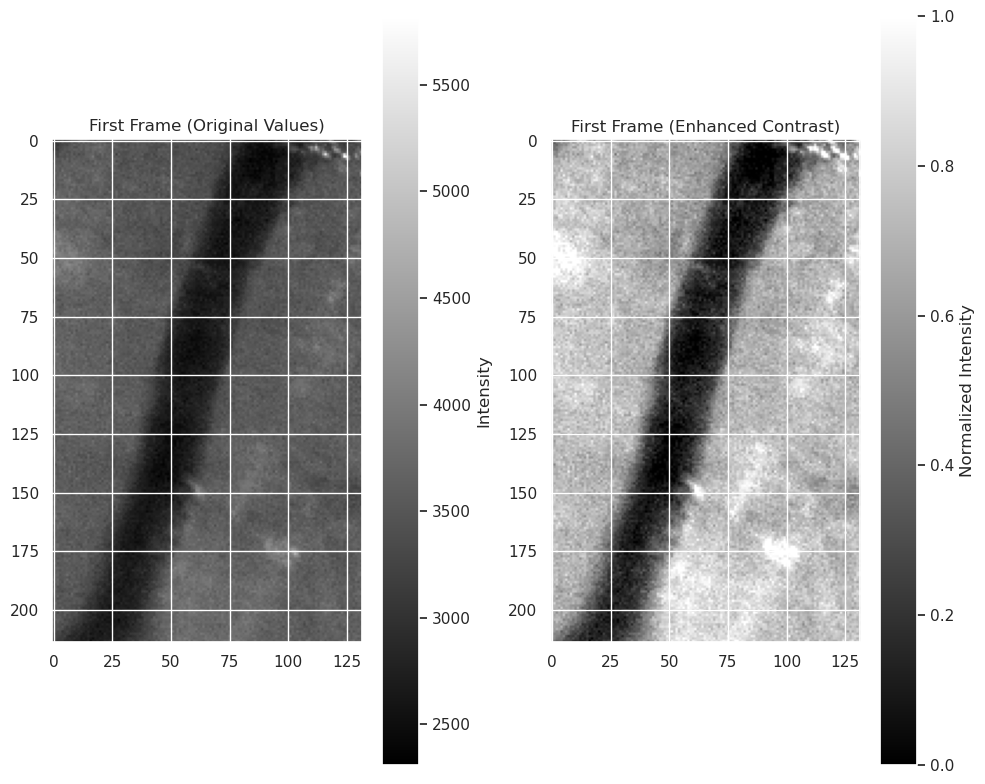

In [6]:
# Function to enhance contrast for better visualization
def enhance_contrast(image, percentile_low=1, percentile_high=99):
    """Enhance image contrast for better visualization."""
    if image.size == 0:
        print("Warning: Empty image array provided to enhance_contrast")
        return np.zeros((1, 1))  # Return a dummy image to avoid further errors
    
    low = np.percentile(image, percentile_low)
    high = np.percentile(image, percentile_high)
    image_scaled = np.clip((image - low) / (high - low), 0, 1)
    return image_scaled

# Get the first frame
first_frame = movies.data[0]

# Plot the first frame
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(first_frame, cmap='gray')
plt.colorbar(label='Intensity')
plt.title('First Frame (Original Values)')

# Plot with enhanced contrast
plt.subplot(1, 2, 2)
plt.imshow(enhance_contrast(first_frame), cmap='gray')
plt.colorbar(label='Normalized Intensity')
plt.title('First Frame (Enhanced Contrast)')

plt.tight_layout()
plt.show()

The image shows a pial vessel network in a mouse. The bright structures are the blood vessels, with the main vessel running diagonally across the field of view. Enhancing the contrast helps to better visualize the vessel boundaries, which is important for diameter measurements.

Let's also look at a frame from the middle of the recording to see if there are any significant differences.

Frame dimensions: 214 x 132


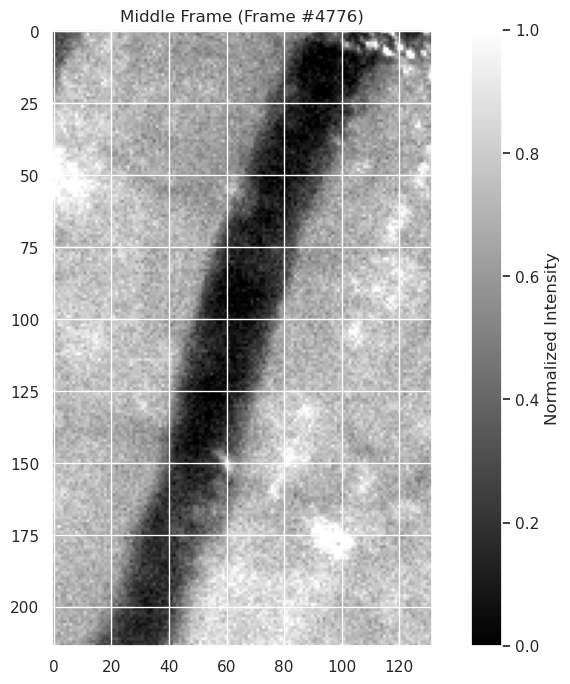

In [7]:
# Get a frame from the middle of the recording
middle_idx = movies.data.shape[0] // 2
middle_frame = movies.data[middle_idx]

# Print the frame dimensions
frame_height, frame_width = middle_frame.shape
print(f"Frame dimensions: {frame_height} x {frame_width}")

# Plot the middle frame with enhanced contrast
plt.figure(figsize=(10, 8))
plt.imshow(enhance_contrast(middle_frame), cmap='gray')
plt.colorbar(label='Normalized Intensity')
plt.title(f'Middle Frame (Frame #{middle_idx})')
plt.show()

## Temporal Analysis of Vessel Pulsation

To visualize vessel pulsation, we can create a few different visualizations:

1. Difference image between consecutive frames to highlight motion
2. Standard deviation projection across multiple frames to show areas of high temporal variance
3. Maximum intensity projection across multiple frames

Let's create these visualizations:

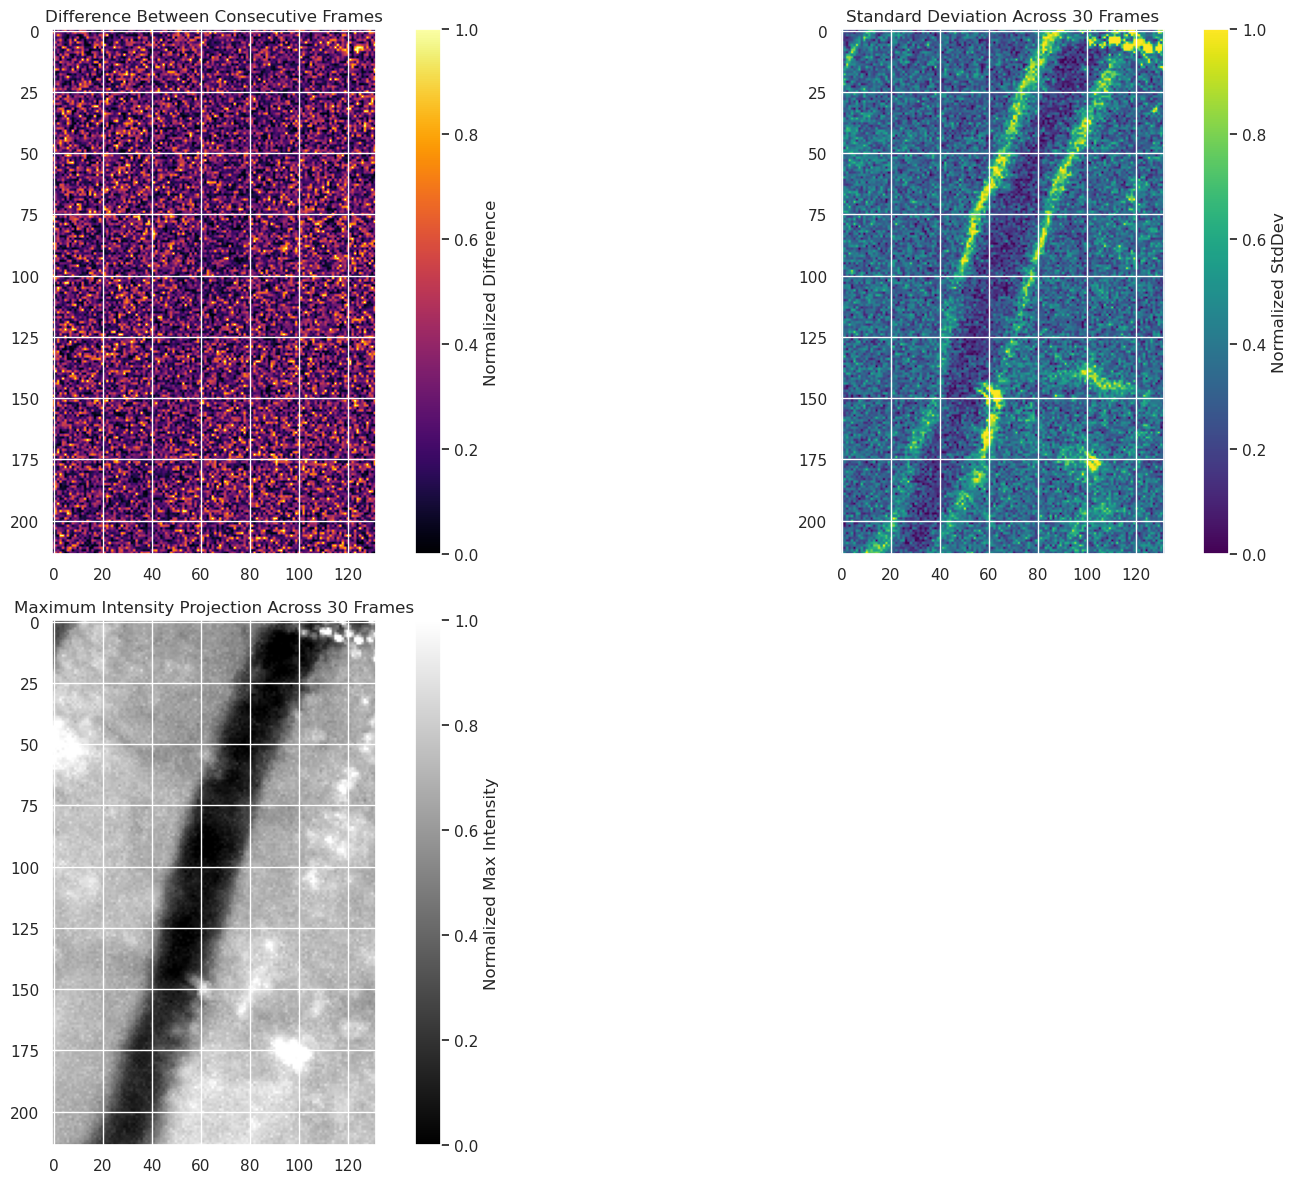

In [8]:
# Extract a short sequence of frames (30 frames = 1 second at 30 Hz)
n_frames = 30
start_idx = middle_idx - n_frames // 2
frames_subset = np.array([movies.data[i] for i in range(start_idx, start_idx + n_frames)])

# Create a difference image between consecutive frames
frame1 = movies.data[middle_idx]
frame2 = movies.data[middle_idx + 1]
diff_image = np.abs(frame2.astype(np.float32) - frame1.astype(np.float32))

# Create a standard deviation projection
std_projection = np.std(frames_subset, axis=0)

# Create a maximum intensity projection
max_projection = np.max(frames_subset, axis=0)

# Plot all three visualizations
plt.figure(figsize=(16, 12))

# Difference image
plt.subplot(2, 2, 1)
plt.imshow(enhance_contrast(diff_image), cmap='inferno')
plt.colorbar(label='Normalized Difference')
plt.title(f'Difference Between Consecutive Frames')

# Standard deviation projection
plt.subplot(2, 2, 2)
plt.imshow(enhance_contrast(std_projection), cmap='viridis')
plt.colorbar(label='Normalized StdDev')
plt.title(f'Standard Deviation Across {n_frames} Frames')

# Maximum intensity projection
plt.subplot(2, 2, 3)
plt.imshow(enhance_contrast(max_projection), cmap='gray')
plt.colorbar(label='Normalized Max Intensity')
plt.title(f'Maximum Intensity Projection Across {n_frames} Frames')

plt.tight_layout()
plt.show()

These visualizations provide different information about vessel pulsation:

- The **difference image** highlights areas with frame-to-frame changes, showing where vessel movement occurs between consecutive frames.

- The **standard deviation projection** reveals regions with high temporal variability across 30 frames (1 second). Brighter areas indicate higher variance, which often corresponds to vessel walls that move due to pulsation.

- The **maximum intensity projection** shows the maximum intensity at each pixel across all frames, providing a structural overview of the vessel network.

The standard deviation projection is particularly useful for identifying regions with vessel pulsation, as it highlights areas with consistent temporal variance across multiple frames.

## Vessel Diameter Measurement Using Full Width at Half Maximum (FWHM)

One approach to measure vessel diameter is the Full Width at Half Maximum (FWHM) method, which measures the width of a vessel at half the peak intensity. Let's implement this method and analyze a vessel segment.

Frame dimensions: 214 x 132
ROI coordinates: (39, 64) to (92, 149)
ROI shape: (85, 53)


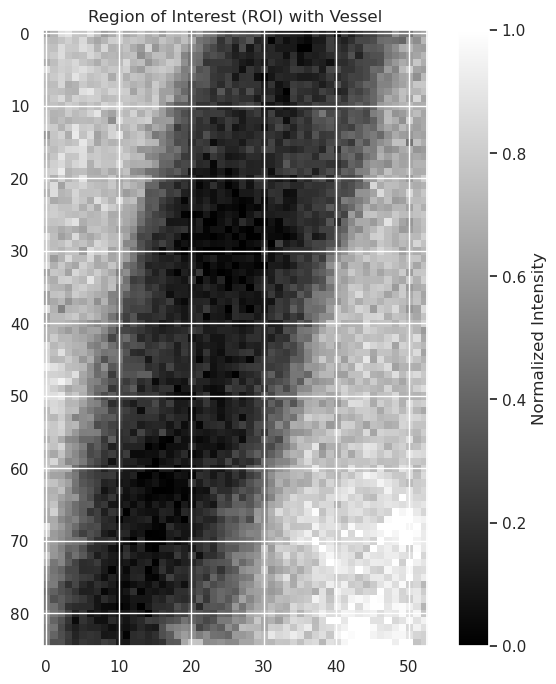

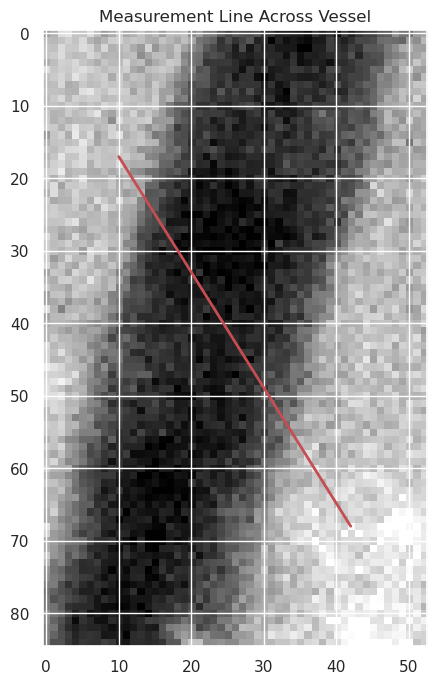

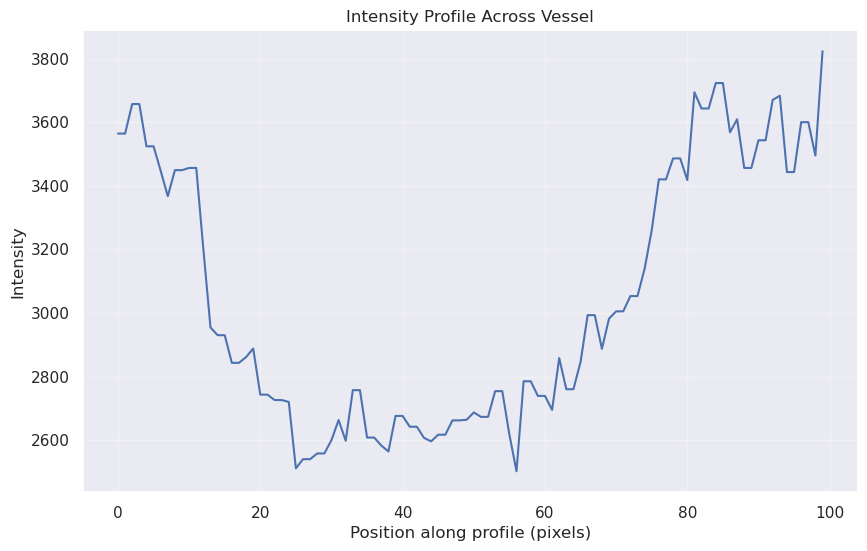

In [9]:
# Check frame dimensions and define a suitable ROI
frame_height, frame_width = middle_frame.shape
print(f"Frame dimensions: {frame_height} x {frame_width}")

# Adjust ROI coordinates to ensure they're within the frame dimensions
# Using percentages of the frame size for more adaptability
roi_x1 = int(frame_width * 0.3)
roi_y1 = int(frame_height * 0.3)
roi_x2 = int(frame_width * 0.7)
roi_y2 = int(frame_height * 0.7)

# Make sure coordinates are within bounds
roi_x1 = max(0, min(roi_x1, frame_width - 2))
roi_y1 = max(0, min(roi_y1, frame_height - 2))
roi_x2 = max(roi_x1 + 1, min(roi_x2, frame_width))
roi_y2 = max(roi_y1 + 1, min(roi_y2, frame_height))

print(f"ROI coordinates: ({roi_x1}, {roi_y1}) to ({roi_x2}, {roi_y2})")

# Extract the ROI
roi = middle_frame[roi_y1:roi_y2, roi_x1:roi_x2]
print(f"ROI shape: {roi.shape}")

# Visualize the ROI
plt.figure(figsize=(8, 8))
plt.imshow(enhance_contrast(roi), cmap='gray')
plt.title('Region of Interest (ROI) with Vessel')
plt.colorbar(label='Normalized Intensity')
plt.show()

# Function to extract an intensity profile along a line
def extract_profile(image, x1, y1, x2, y2, num_points=100):
    """Extract intensity profile along a line from (x1, y1) to (x2, y2)."""
    # Make sure coordinates are within image bounds
    h, w = image.shape
    x1 = max(0, min(x1, w-1))
    y1 = max(0, min(y1, h-1))
    x2 = max(0, min(x2, w-1))
    y2 = max(0, min(y2, h-1))
    
    # Extract coordinates along the line
    x = np.linspace(x1, x2, num_points).astype(int)
    y = np.linspace(y1, y2, num_points).astype(int)
    
    # Extract values along the line
    return image[y, x]

# Calculate suitable measurement line coordinates (scaled to ROI size)
roi_height, roi_width = roi.shape
perp_x1 = int(roi_width * 0.2)
perp_y1 = int(roi_height * 0.2)
perp_x2 = int(roi_width * 0.8)
perp_y2 = int(roi_height * 0.8)

# Extract intensity profile
profile = extract_profile(roi, perp_x1, perp_y1, perp_x2, perp_y2)

# Visualize the ROI with the measurement line
plt.figure(figsize=(8, 8))
plt.imshow(enhance_contrast(roi), cmap='gray')
plt.plot([perp_x1, perp_x2], [perp_y1, perp_y2], 'r-', linewidth=2)
plt.title('Measurement Line Across Vessel')
plt.show()

# Plot the intensity profile
plt.figure(figsize=(10, 6))
plt.plot(profile, 'b-', linewidth=1.5)
plt.title('Intensity Profile Across Vessel')
plt.xlabel('Position along profile (pixels)')
plt.ylabel('Intensity')
plt.grid(True, alpha=0.3)
plt.show()

Now let's implement the FWHM method to measure the vessel diameter:

In [10]:
# Implement FWHM method for vessel diameter measurement
def estimate_vessel_diameter(profile, pixel_size_um=1.0):
    """Estimate vessel diameter using full width at half maximum (FWHM) method."""
    if len(profile) < 3:
        return None  # Profile too short
        
    # Apply slight smoothing to reduce noise
    profile_smooth = gaussian_filter1d(profile, sigma=1.0)
    
    # Find the approximate background
    background = np.percentile(profile_smooth, 20)
    
    # Find the peak (vessel center)
    # If no clear peaks, use the maximum value
    try:
        peak_idx, _ = find_peaks(profile_smooth, height=np.max(profile_smooth)*0.7)
        if len(peak_idx) == 0:
            peak_idx = [np.argmax(profile_smooth)]
    except:
        peak_idx = [np.argmax(profile_smooth)]
    
    peak_idx = peak_idx[0]  # Take the first peak if multiple found
    peak_value = profile_smooth[peak_idx]
    
    # Calculate half-max value (assumes vessel is brighter than background)
    half_max = background + (peak_value - background) / 2
    
    # Find indices where the profile crosses the half-max
    above_half_max = profile_smooth > half_max
    
    if not np.any(above_half_max):
        return None  # No points above half-max
        
    transitions = np.diff(above_half_max.astype(int))
    rising_indices = np.where(transitions == 1)[0]
    falling_indices = np.where(transitions == -1)[0]
    
    if len(rising_indices) == 0 and len(falling_indices) == 0:
        # No transitions found, but there might still be a vessel
        # if the entire profile is above/below half_max
        if np.all(above_half_max):
            # Everything above half-max, estimate using profile length
            diameter_pixels = len(profile_smooth)
        else:
            # No clear vessel found
            return None
    elif len(rising_indices) == 0 and len(falling_indices) > 0:
        # No rising edge (starts above half-max)
        left_idx = 0
        falling_idx = falling_indices[0]
        diameter_pixels = falling_idx - left_idx
    elif len(rising_indices) > 0 and len(falling_indices) == 0:
        # No falling edge (ends above half-max)
        rising_idx = rising_indices[0]
        right_idx = len(profile_smooth) - 1
        diameter_pixels = right_idx - rising_idx
    else:
        # Both rising and falling edges found
        rising_idx = rising_indices[0]
        falling_candidates = falling_indices[falling_indices > rising_idx]
        
        if len(falling_candidates) == 0:
            # Try another rising edge if no falling edge after first rising
            if len(rising_indices) > 1:
                rising_idx = rising_indices[1]
                falling_candidates = falling_indices[falling_indices > rising_idx]
                if len(falling_candidates) == 0:
                    return None
            else:
                return None
        
        falling_idx = falling_candidates[0]
        diameter_pixels = falling_idx - rising_idx
    
    # Calculate diameter in pixels, then convert to µm if pixel_size is provided
    diameter_um = diameter_pixels * pixel_size_um
    
    result = {
        'diameter_pixels': diameter_pixels,
        'diameter_um': diameter_um,
        'profile_smooth': profile_smooth
    }
    
    # Add additional info if we found proper transitions
    if 'rising_idx' in locals() and 'falling_idx' in locals():
        result.update({
            'peak_idx': peak_idx,
            'rising_idx': rising_idx,
            'falling_idx': falling_idx,
            'half_max': half_max
        })
    
    return result

# Apply FWHM to the profile
diameter_info = estimate_vessel_diameter(profile)

if diameter_info and 'rising_idx' in diameter_info and 'falling_idx' in diameter_info:
    # Visualize the FWHM measurement
    plt.figure(figsize=(12, 6))
    
    # Plot the smoothed profile with FWHM markers
    plt.plot(diameter_info['profile_smooth'], 'b-', linewidth=1.5)
    
    # Mark the half-max line and crossing points
    plt.axhline(y=diameter_info['half_max'], color='r', linestyle='--', alpha=0.7,
                label='Half Maximum')
    plt.axvline(x=diameter_info['rising_idx'], color='g', linestyle='-', alpha=0.7,
                label='FWHM Edges')
    plt.axvline(x=diameter_info['falling_idx'], color='g', linestyle='-', alpha=0.7)
    
    plt.title(f'Vessel Diameter: {diameter_info["diameter_pixels"]:.1f} pixels (using FWHM)')
    plt.xlabel('Position along profile (pixels)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Vessel diameter: {diameter_info['diameter_pixels']:.1f} pixels")
elif diameter_info:
    # We have diameter info but not the full set of markers
    plt.figure(figsize=(12, 6))
    plt.plot(diameter_info['profile_smooth'], 'b-', linewidth=1.5)
    plt.title(f'Vessel Diameter: {diameter_info["diameter_pixels"]:.1f} pixels (estimated)')
    plt.xlabel('Position along profile (pixels)')
    plt.ylabel('Intensity')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Vessel diameter (estimated): {diameter_info['diameter_pixels']:.1f} pixels")
else:
    print("Could not determine vessel diameter: no clear vessel boundaries detected.")

Could not determine vessel diameter: no clear vessel boundaries detected.


## Analyzing Vessel Diameter Over Time

To study vessel pulsatility, we need to track diameter changes over time. Let's analyze how the vessel diameter changes across multiple frames.

Extracted 20 valid ROIs of shape (85, 53)
Analyzing vessel diameter over time...


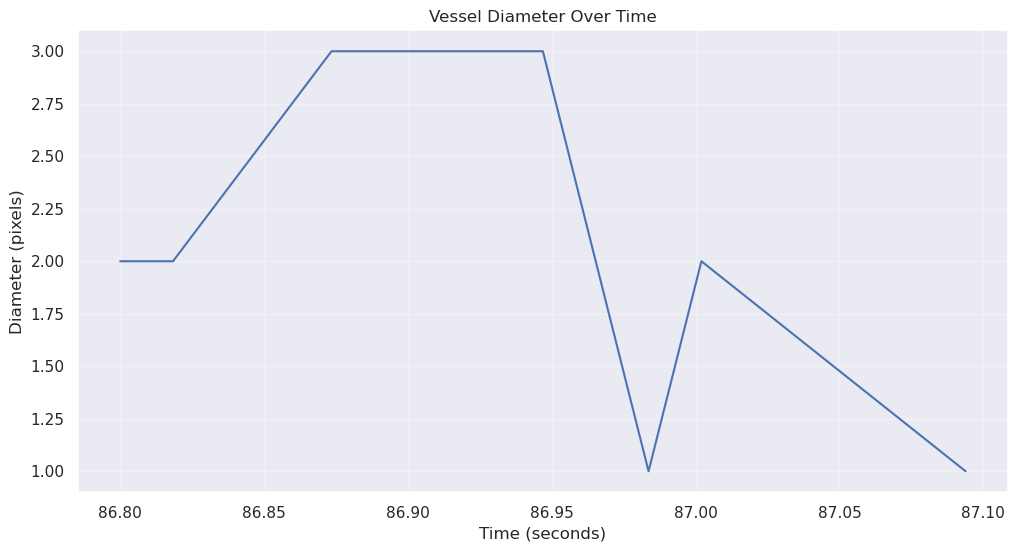

Mean vessel diameter: 2.00 pixels
Standard deviation: 0.76 pixels
Pulsatility (max-min/avg): 100.00%


In [11]:
# Define the time window for analysis
start_frame = middle_idx - 50  # Starting from near the middle frame
frame_count = 20   # Analyze 20 frames (use a smaller sample for faster execution)

# Safe extraction of ROI for each frame
def safe_extract_roi(frame, y1, y2, x1, x2):
    """Safely extract a region of interest from a frame."""
    h, w = frame.shape
    # Ensure coordinates are within bounds
    y1 = max(0, min(y1, h-2))
    y2 = max(y1+1, min(y2, h))
    x1 = max(0, min(x1, w-2))
    x2 = max(x1+1, min(x2, w))
    return frame[y1:y2, x1:x2]

# Extract the ROI for each frame
roi_frames = []
valid_indices = []
for i in range(start_frame, start_frame + frame_count):
    if i < 0 or i >= movies.data.shape[0]:
        continue  # Skip if index is out of bounds
    frame = movies.data[i]
    roi = safe_extract_roi(frame, roi_y1, roi_y2, roi_x1, roi_x2)
    if roi.size > 0:  # Only append non-empty ROIs
        roi_frames.append(roi)
        valid_indices.append(i)

if not roi_frames:
    print("No valid ROIs extracted. Adjust ROI coordinates.")
else:
    roi_frames = np.array(roi_frames)
    print(f"Extracted {len(roi_frames)} valid ROIs of shape {roi_frames[0].shape}")

    # Analyze vessel diameter over time
    print("Analyzing vessel diameter over time...")
    diameters = []
    timestamps = []
    sampling_rate = movies.rate  # Hz

    for i, (roi, orig_idx) in enumerate(zip(roi_frames, valid_indices)):
        if perp_x2 >= roi.shape[1] or perp_y2 >= roi.shape[0]:
            # Adjust perp coordinates to fit this ROI
            p_x1 = int(roi.shape[1] * 0.2)
            p_y1 = int(roi.shape[0] * 0.2)
            p_x2 = int(roi.shape[1] * 0.8)
            p_y2 = int(roi.shape[0] * 0.8)
        else:
            p_x1, p_y1, p_x2, p_y2 = perp_x1, perp_y1, perp_x2, perp_y2
            
        profile = extract_profile(roi, p_x1, p_y1, p_x2, p_y2)
        diameter_info = estimate_vessel_diameter(profile)
        
        if diameter_info:
            diameters.append(diameter_info['diameter_pixels'])
            # Calculate timestamp in seconds
            time_sec = orig_idx / sampling_rate
            timestamps.append(time_sec)

    if not diameters:
        print("Could not measure any diameters across frames.")
    else:
        # Plot diameter over time
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, diameters, 'b-')
        plt.title('Vessel Diameter Over Time')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Diameter (pixels)')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Calculate basic statistics
        mean_diameter = np.mean(diameters)
        std_diameter = np.std(diameters)
        pulsatility = (np.max(diameters) - np.min(diameters)) / mean_diameter * 100  # in percent

        print(f"Mean vessel diameter: {mean_diameter:.2f} pixels")
        print(f"Standard deviation: {std_diameter:.2f} pixels")
        print(f"Pulsatility (max-min/avg): {pulsatility:.2f}%")

The time series of vessel diameter shows changes over time, which may correspond to pulsation related to the cardiac cycle of the mouse. The pulsatility index, calculated as (max-min)/mean diameter, quantifies the relative change in vessel diameter.

## Frequency Analysis of Vessel Pulsation

If we have enough diameter measurements, we can perform frequency analysis to identify potential pulsation frequencies.

In [12]:
# Only run frequency analysis if we have enough data points
if 'diameters' in locals() and len(diameters) > 10:
    # Detrend the diameter data to remove any linear trend
    diameters_detrended = detrend(diameters)
    
    # Compute power spectral density
    fs = sampling_rate  # sampling frequency (same as movie frame rate)
    nperseg = min(len(diameters_detrended), 16)  # Adjust segment size based on data length
    
    f, Pxx = welch(diameters_detrended, fs=fs, nperseg=nperseg)
    
    # Plot the power spectral density
    plt.figure(figsize=(12, 6))
    plt.semilogy(f, Pxx)
    plt.title('Power Spectral Density of Vessel Diameter Variations')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    if len(Pxx) > 1:
        # Find the peak frequency (excluding DC component at 0 Hz)
        peak_freq_idx = np.argmax(Pxx[1:]) + 1  # Skip the first point (0 Hz)
        peak_freq = f[peak_freq_idx]
        
        print(f"Dominant pulsation frequency: {peak_freq:.2f} Hz")
        print(f"Corresponding to a period of {1/peak_freq:.2f} seconds")
    else:
        print("Not enough data points for frequency analysis")
else:
    print("Not enough diameter measurements for frequency analysis")

Not enough diameter measurements for frequency analysis


## Radon Transform for Vessel Orientation and Diameter Analysis

Another approach mentioned in the Dandiset keywords is the Radon transform, which can be used to determine vessel orientation and subsequently measure vessel diameter. Let's demonstrate this method.

/opt/conda/lib/python3.11/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


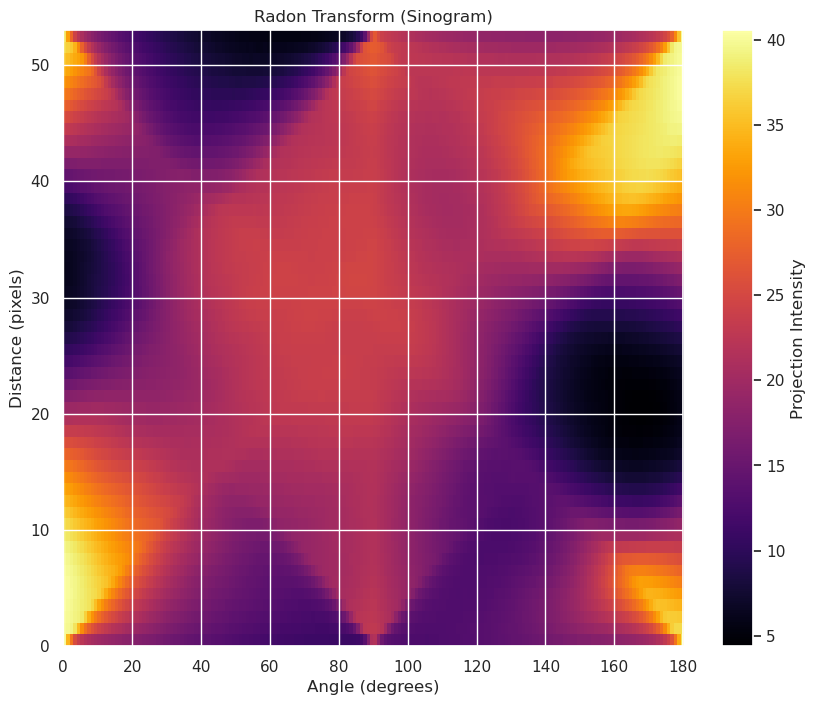

Detected vessel angle: 0.00 degrees
Perpendicular angle: 90.00 degrees


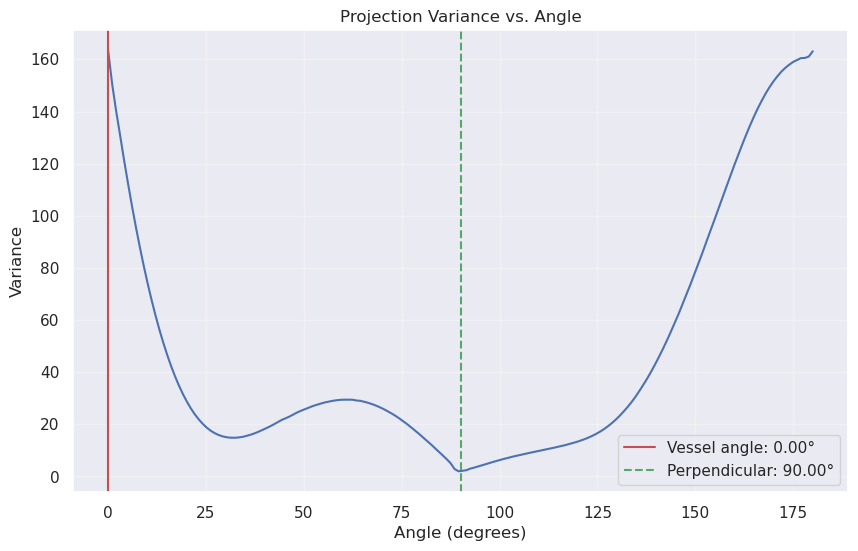

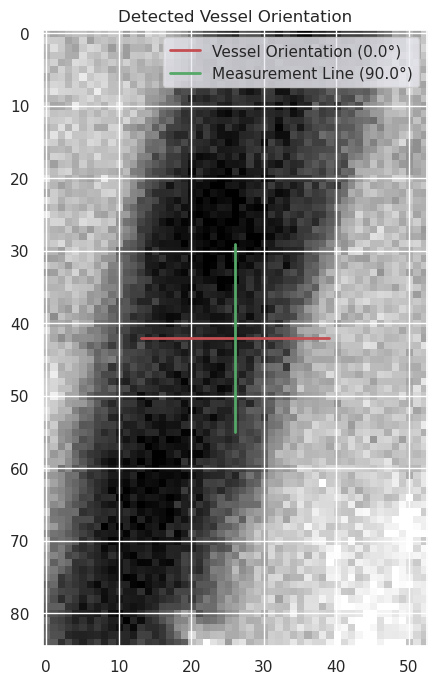

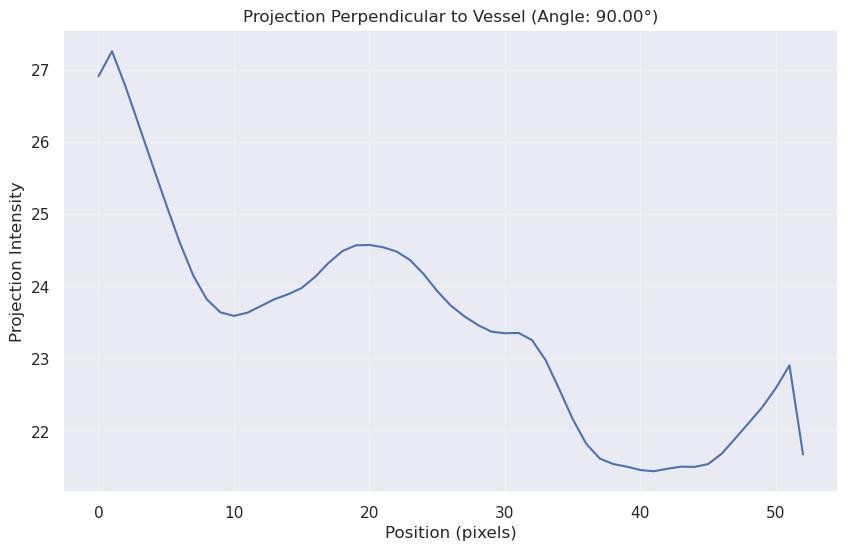

In [13]:
# Check if we have a valid ROI to use for Radon transform
if 'roi' in locals() and roi.size > 0 and roi.shape[0] > 10 and roi.shape[1] > 10:
    # Preprocess the ROI for Radon transform analysis
    roi_enhanced = enhance_contrast(roi)
    roi_smoothed = gaussian_filter(roi_enhanced, sigma=1.5)
    
    # Apply Radon Transform to the ROI
    # The radon transform takes projections of an image along specified angles
    theta = np.linspace(0., 180., 180)  # Angles in degrees
    sinogram = radon(roi_smoothed, theta=theta)
    
    # Plot the Radon Transform (sinogram)
    plt.figure(figsize=(10, 8))
    plt.imshow(sinogram, cmap='inferno', aspect='auto', 
               extent=(0, 180, 0, sinogram.shape[0]))
    plt.title('Radon Transform (Sinogram)')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Distance (pixels)')
    plt.colorbar(label='Projection Intensity')
    plt.show()
    
    # Find the angle with the highest variance in the projections
    projection_variance = np.var(sinogram, axis=0)
    max_var_angle_idx = np.argmax(projection_variance)
    vessel_angle = theta[max_var_angle_idx]
    perpendicular_angle = (vessel_angle + 90) % 180
    
    print(f"Detected vessel angle: {vessel_angle:.2f} degrees")
    print(f"Perpendicular angle: {perpendicular_angle:.2f} degrees")
    
    # Plot the variance of projections at different angles
    plt.figure(figsize=(10, 6))
    plt.plot(theta, projection_variance)
    plt.axvline(x=vessel_angle, color='r', linestyle='-', 
                label=f'Vessel angle: {vessel_angle:.2f}°')
    plt.axvline(x=perpendicular_angle, color='g', linestyle='--', 
                label=f'Perpendicular: {perpendicular_angle:.2f}°')
    plt.title('Projection Variance vs. Angle')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Visualize the detected vessel orientation
    plt.figure(figsize=(8, 8))
    plt.imshow(roi_enhanced, cmap='gray')
    
    # Calculate the center of the ROI
    center_y, center_x = roi_enhanced.shape[0] // 2, roi_enhanced.shape[1] // 2
    
    # Calculate endpoints for a line along the vessel orientation (red line)
    length = min(roi.shape) // 4  # Adjust line length based on ROI size
    angle_rad = np.deg2rad(vessel_angle)
    dx = length * np.cos(angle_rad)
    dy = length * np.sin(angle_rad)
    x1_vessel, y1_vessel = center_x - dx, center_y - dy
    x2_vessel, y2_vessel = center_x + dx, center_y + dy
    
    # Calculate endpoints for a line perpendicular to the vessel (green line)
    perp_angle_rad = np.deg2rad(perpendicular_angle)
    dx_perp = length * np.cos(perp_angle_rad)
    dy_perp = length * np.sin(perp_angle_rad)
    x1_perp, y1_perp = center_x - dx_perp, center_y - dy_perp
    x2_perp, y2_perp = center_x + dx_perp, center_y + dy_perp
    
    # Draw the lines on the plot
    plt.plot([x1_vessel, x2_vessel], [y1_vessel, y2_vessel], 'r-', linewidth=2, 
             label=f'Vessel Orientation ({vessel_angle:.1f}°)')
    plt.plot([x1_perp, x2_perp], [y1_perp, y2_perp], 'g-', linewidth=2, 
             label=f'Measurement Line ({perpendicular_angle:.1f}°)')
    
    plt.title('Detected Vessel Orientation')
    plt.legend(loc='upper right')
    plt.show()
    
    # Extract the projection perpendicular to the vessel
    perpendicular_idx = int((perpendicular_angle / 180) * len(theta))
    if perpendicular_idx >= len(theta):
        perpendicular_idx = len(theta) - 1
    perpendicular_projection = sinogram[:, perpendicular_idx]
    
    # Plot the projection perpendicular to the vessel
    plt.figure(figsize=(10, 6))
    plt.plot(perpendicular_projection)
    plt.title(f'Projection Perpendicular to Vessel (Angle: {perpendicular_angle:.2f}°)')
    plt.xlabel('Position (pixels)')
    plt.ylabel('Projection Intensity')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Valid ROI not available for Radon transform analysis")

If we were able to compute the Radon transform, we can apply the FWHM method to the perpendicular projection to measure the vessel diameter:

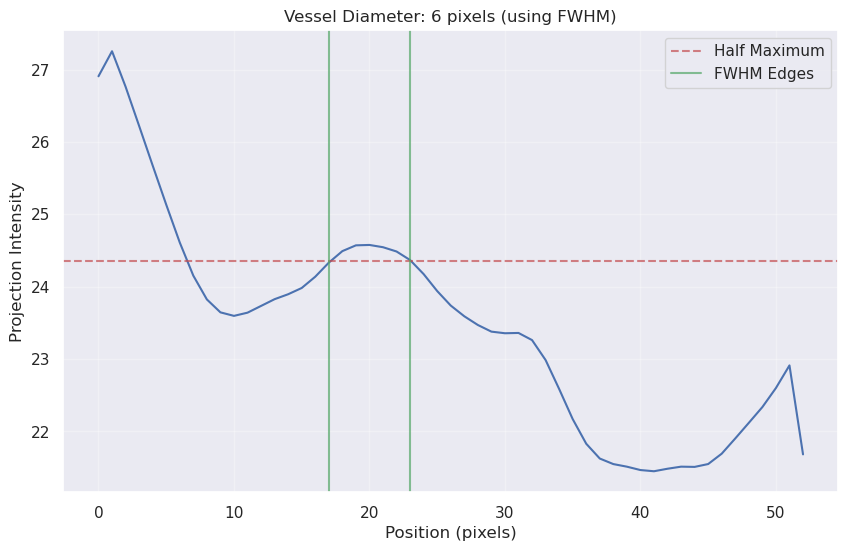

Vessel diameter (Radon + FWHM): 6 pixels


In [14]:
# Check if perpendicular projection exists
if 'perpendicular_projection' in locals() and len(perpendicular_projection) > 0:
    # Function to find vessel diameter using FWHM
    def find_vessel_diameter_fwhm(projection):
        # Find the peak
        peak_idx = np.argmax(projection)
        peak_value = projection[peak_idx]
        
        # Determine the baseline
        baseline = np.min(projection)
        
        # Calculate half-max value
        half_max = baseline + (peak_value - baseline) / 2
        
        # Find where the projection crosses the half-max
        above_half_max = projection > half_max
        if not np.any(above_half_max):
            return None
            
        transitions = np.diff(above_half_max.astype(int))
        rising_indices = np.where(transitions == 1)[0]
        falling_indices = np.where(transitions == -1)[0]
        
        # Handle various cases
        if len(rising_indices) == 0 and len(falling_indices) == 0:
            if np.all(above_half_max):  # Everything is above half-max
                diameter = len(projection)
                return {'diameter': diameter, 'half_max': half_max}
            return None  # No clear vessel
            
        if len(rising_indices) == 0:  # Starts above half-max
            left_idx = 0
            if len(falling_indices) == 0:  # Also ends above half-max
                right_idx = len(projection) - 1
            else:
                right_idx = falling_indices[0]
        elif len(falling_indices) == 0:  # Ends above half-max
            left_idx = rising_indices[-1]
            right_idx = len(projection) - 1
        else:
            # Both rising and falling edges found
            # Find first rising edge
            left_idx = rising_indices[0]
            # Find next falling edge after rising
            falling_after_rising = falling_indices[falling_indices > left_idx]
            if len(falling_after_rising) == 0:
                # No falling edge after rising, use next rising
                if len(rising_indices) > 1:
                    left_idx = rising_indices[1]
                    falling_after_rising = falling_indices[falling_indices > left_idx]
                    if len(falling_after_rising) == 0:
                        right_idx = len(projection) - 1
                    else:
                        right_idx = falling_after_rising[0]
                else:
                    right_idx = len(projection) - 1
            else:
                right_idx = falling_after_rising[0]
        
        # Calculate diameter
        diameter = right_idx - left_idx
        
        return {
            'diameter': diameter,
            'half_max': half_max,
            'left_idx': left_idx,
            'right_idx': right_idx
        }

    # Apply FWHM to the perpendicular projection
    diameter_info_radon = find_vessel_diameter_fwhm(perpendicular_projection)

    # Visualize the FWHM measurement if valid info returned
    if diameter_info_radon and 'left_idx' in diameter_info_radon and 'right_idx' in diameter_info_radon:
        plt.figure(figsize=(10, 6))
        plt.plot(perpendicular_projection, 'b-', linewidth=1.5)
        plt.axhline(y=diameter_info_radon['half_max'], color='r', linestyle='--', alpha=0.7, 
                    label='Half Maximum')
        plt.axvline(x=diameter_info_radon['left_idx'], color='g', linestyle='-', alpha=0.7,
                    label='FWHM Edges')
        plt.axvline(x=diameter_info_radon['right_idx'], color='g', linestyle='-', alpha=0.7)
        plt.title(f'Vessel Diameter: {diameter_info_radon["diameter"]} pixels (using FWHM)')
        plt.xlabel('Position (pixels)')
        plt.ylabel('Projection Intensity')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"Vessel diameter (Radon + FWHM): {diameter_info_radon['diameter']} pixels")
    elif diameter_info_radon:
        plt.figure(figsize=(10, 6))
        plt.plot(perpendicular_projection, 'b-', linewidth=1.5)
        plt.axhline(y=diameter_info_radon['half_max'], color='r', linestyle='--', alpha=0.7, 
                    label='Half Maximum')
        plt.title(f'Vessel Diameter (estimated): {diameter_info_radon["diameter"]} pixels')
        plt.xlabel('Position (pixels)')
        plt.ylabel('Projection Intensity')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"Vessel diameter (estimated): {diameter_info_radon['diameter']} pixels")
    else:
        print("Could not determine vessel diameter from Radon transform")

## Comparison of Different Methods

We have demonstrated two different approaches for vessel diameter measurement:

1. **Direct FWHM:** Directly measuring the full width at half maximum on an intensity profile across the vessel.

2. **Radon Transform + FWHM:** Using Radon transform to determine vessel orientation, then applying FWHM to the projection perpendicular to the vessel.

Both methods have their advantages. The Radon transform approach has the benefit of automatically determining the vessel orientation, which ensures that the diameter measurement is taken perpendicular to the vessel.

## Second NWB File Analysis

Let's also briefly explore the second NWB file in the Dandiset to see how it compares to the first one.

Loading second NWB file from asset: sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb



Second NWB File Information:
Session description: the mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head plate for fixation.
Subject ID: 031224_M4
Subject species: Mus musculus
Subject sex: M
Subject age: P2M

Movies data information:
Dimensions: (6000, 512, 512)
Sampling rate: 30.0 Hz


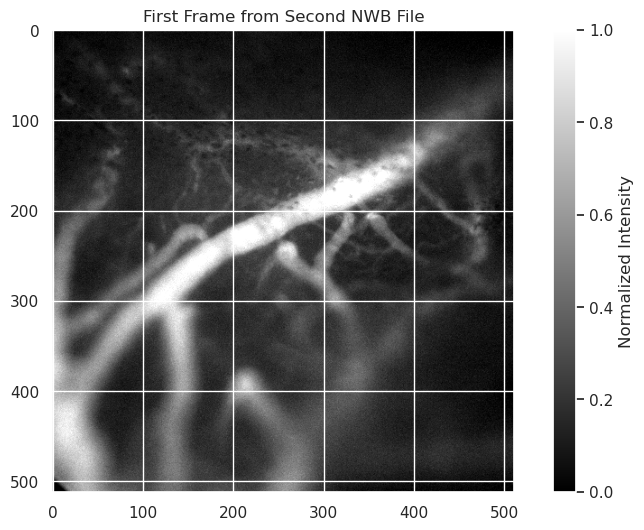

In [15]:
# Check if there's a second NWB file
if len(assets) > 1:
    try:
        asset_id_2 = assets[1].identifier
        print(f"Loading second NWB file from asset: {assets[1].path}")
        
        # Use lindi to load the remote NWB file
        lindi_url_2 = f"https://lindi.neurosift.org/dandi/dandisets/001366/assets/{asset_id_2}/nwb.lindi.json"
        f2 = lindi.LindiH5pyFile.from_lindi_file(lindi_url_2)
        nwb2 = pynwb.NWBHDF5IO(file=f2, mode='r').read()
        
        # Print basic information
        print("\nSecond NWB File Information:")
        print(f"Session description: {nwb2.session_description}")
        print(f"Subject ID: {nwb2.subject.subject_id}")
        print(f"Subject species: {nwb2.subject.species}")
        print(f"Subject sex: {nwb2.subject.sex}")
        print(f"Subject age: {nwb2.subject.age}")
        
        # Get movie information
        movies2 = nwb2.acquisition["Movies"]
        print(f"\nMovies data information:")
        print(f"Dimensions: {movies2.data.shape}")
        print(f"Sampling rate: {movies2.rate} Hz")
        
        # Visualize a frame
        first_frame2 = movies2.data[0]
        plt.figure(figsize=(10, 6))
        plt.imshow(enhance_contrast(first_frame2), cmap='gray')
        plt.colorbar(label='Normalized Intensity')
        plt.title(f'First Frame from Second NWB File')
        plt.show()
    except Exception as e:
        print(f"Error loading second NWB file: {e}")
else:
    print("No second NWB file found in the Dandiset.")

## Summary and Conclusion

In this notebook, we have explored Dandiset 001366, which contains imaging data of pial vessels in mice used for vessel diameter and pulsatility quantification.

We have demonstrated:

1. **Loading and exploring NWB files** from the Dandiset using lindi and pynwb.

2. **Visualizing vessel images** with different contrast enhancements.

3. **Temporal analysis techniques** including difference images, standard deviation projection, and maximum intensity projection to visualize vessel pulsation.

4. **Diameter measurement methods** including:
   - Direct Full Width at Half Maximum (FWHM) on intensity profiles
   - Radon Transform for vessel orientation detection followed by FWHM measurement

5. **Pulsatility analysis** by tracking vessel diameter over time and performing frequency analysis to identify the dominant pulsation frequency.

The dataset provides valuable resources for researchers interested in methods for quantifying vessel diameter and pulsatility, especially the comparison between Radon transform-based approaches and FWHM methods.

## References and Resources

- Dandiset 001366: https://dandiarchive.org/dandiset/001366
- DANDI: Distributed Archives for Neurophysiology Data Integration: https://dandiarchive.org/
- Neurodata Without Borders (NWB): https://www.nwb.org/
- Lindi: https://github.com/flatironinstitute/lindi

## Required Packages

To run this notebook, you need the following Python packages:

- numpy
- matplotlib
- scipy
- pynwb
- lindi
- scikit-image
- dandi
- seaborn